In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
workspaceFolder = "/home/gabor/Projects/bnn_seq_vi"
seq_args = [
    "--seed=3",
    # f"--pretrained_prior_checkpoint={workspaceFolder}/bnn_hmc/.runs/vi/regtest2/mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.001___epochs_300_wd_0.5_batchsize_1_temp_1.0__seed_11/model_step_299.pt",
    f"--dir={workspaceFolder}/bnn_hmc/.runs/sgd/visualize/",
    "--dataset_name=regtest_1",
    "--model_name=bayesian_regression",
]

In [3]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
os.chdir("../..")

In [4]:
from jax import numpy as jnp
import jax
import pandas as pd
import tensorflow.compat.v2 as tf
import argparse

from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import optim_utils
from bnn_hmc.utils import script_utils
from bnn_hmc.core import vi

parser = argparse.ArgumentParser(description="Run SGD on a cloud TPU")
cmd_args_utils.add_common_flags(parser)
cmd_args_utils.add_sgd_flags(parser)
parser.add_argument("--vi_sigma_init", default=1e-3)

args = parser.parse_args(seq_args)
train_utils.set_up_jax(args.tpu_ip, args.use_float64)

2024-09-15 20:26:40.816639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-15 20:26:42.409500: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
(train_set, test_set, net_apply, params, net_state, key, log_likelihood_fn,
   log_prior_fn, _, predict_fn, ensemble_upd_fn, metrics_fns,
   tabulate_metrics) = script_utils.get_data_model_fns(args)

In [7]:
SGD_CHECKPOINT_DIR = f"{workspaceFolder}/bnn_hmc/.runs/sgd/regtest/"\
                     "sgd_mom_0.9__lr_sch_i_0.0005___epochs_500_wd_10.0_batchsize_1_temp_1.0__seed_1/"

In [36]:
checkpoints = filter(lambda s: s.startswith("model_step_"), os.listdir(SGD_CHECKPOINT_DIR))
checkpoint_iters = map(lambda s: int(re.match(r"^model_step_(\d+).pt", s).group(1)), checkpoints)
checkpoints = [f"model_step_{iter}.pt" for iter in sorted(checkpoint_iters)]

In [37]:
checkpoint_files = {
    checkpoint: os.path.join(SGD_CHECKPOINT_DIR, checkpoint)
    for checkpoint in checkpoints
}

In [38]:
test_x = test_set[0][0, ..., 0]

def process_checkpoint_file(checkpoint_file, ax=None):
    sgd_params = checkpoint_utils.load_checkpoint(checkpoint_file)['params']
    _, test_predictions, train_predictions, test_stats, train_stats_ = script_utils.evaluate(
        net_apply, sgd_params, net_state, train_set, test_set, predict_fn, metrics_fns, log_prior_fn)

    map_mean = test_predictions[0, ..., 0]
    predictive_std = test_predictions[0, ..., 1]

    if not ax:
        fig, ax = plt.subplots()
    ax.errorbar(test_x, map_mean, yerr=predictive_std)
    ax.hlines(y=0, xmin=-2, xmax=2, alpha=0.2)

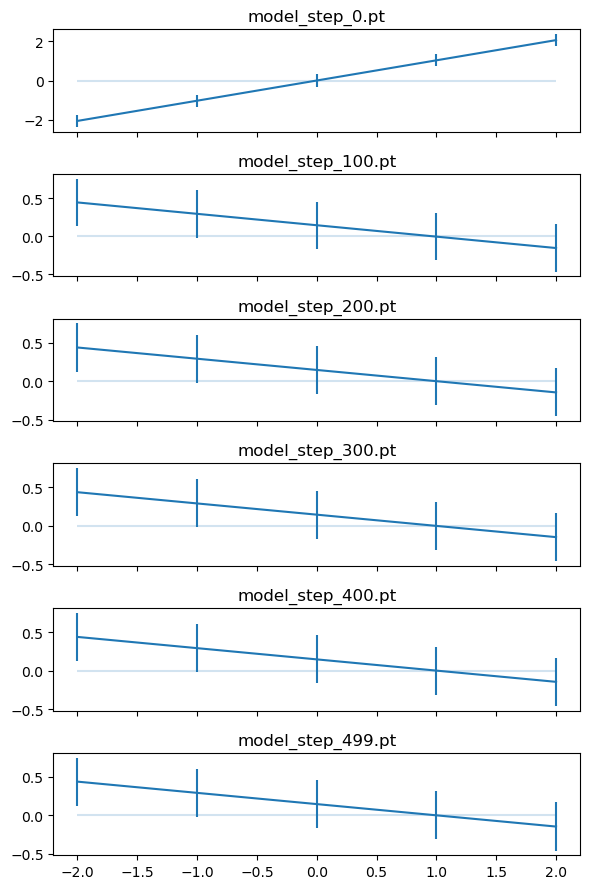

In [41]:
fig, axs = plt.subplots(nrows=len(checkpoint_files), figsize=(6, 9),#(len(checkpoint_files)*100, 400))
                        sharex=True, sharey=False)
for (checkpoint, checkpoint_file), ax in zip(checkpoint_files.items(), axs.ravel()):
    ax.set_title(checkpoint)
    process_checkpoint_file(checkpoint_file, ax=ax)
fig.tight_layout()
plt.show()